In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [14]:
import yfinance as yf

# List of Indian stock tickers you want to analyze. I'm using some example tickers here.
tickers = ["INFY.NS", "RELIANCE.NS", "TATAMOTORS.NS", "ICICIBANK.NS", "ITC.NS"]

# Downloading data for the last 5 years
stock_data = yf.download(tickers, start="2019-08-01", end="2023-08-01")['Adj Close']
print(stock_data.head())



[*********************100%%**********************]  5 of 5 completed
            ICICIBANK.NS     INFY.NS      ITC.NS  RELIANCE.NS  TATAMOTORS.NS
Date                                                                        
2019-08-01    406.615570  685.420349  225.989578  1151.198608     129.147491
2019-08-02    400.326935  691.437927  223.413361  1161.594971     130.293915
2019-08-05    392.575867  692.418579  219.443405  1121.382568     123.365509
2019-08-06    399.985687  690.412659  218.683243  1106.621704     122.119392
2019-08-07    398.182007  691.883728  214.248764  1088.084961     117.035240


In [15]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

# Calculate the expected returns and the covariance matrix of daily returns
expected_returns = expected_returns.mean_historical_return(stock_data)
covariance_matrix = risk_models.sample_cov(stock_data)

# Create EfficientFrontier object
ef = EfficientFrontier(expected_returns, covariance_matrix)

# Maximize the Sharpe ratio
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

# Discrete allocation of shares
portfolio_val = 100000  # Example portfolio value in INR
latest_prices = get_latest_prices(stock_data)
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=portfolio_val)
allocation, leftover = da.lp_portfolio()
print("Discrete Allocation:", allocation)
print("Funds Remaining: ₹{:.2f}".format(leftover))


Discrete Allocation: {'ICICIBANK.NS': 10, 'INFY.NS': 11, 'ITC.NS': 55, 'RELIANCE.NS': 5, 'TATAMOTORS.NS': 57}
Funds Remaining: ₹182.14


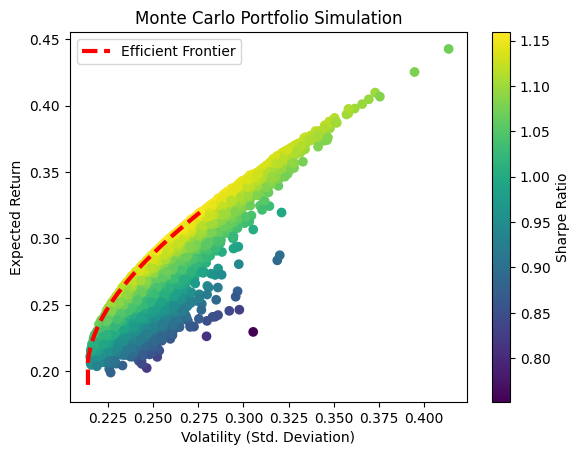

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Monte Carlo simulations to generate portfolios
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    portfolio_return = np.sum(weights * expected_returns)
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    results[0,i] = portfolio_return
    results[1,i] = portfolio_stddev
    results[2,i] = results[0,i] / results[1,i]

# Plot the portfolios
plt.scatter(results[1,:], results[0,:], c=results[2,:], marker='o')
plt.title('Monte Carlo Portfolio Simulation')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')

# Plot Efficient Frontier
max_return, max_volatility, _ = ef.portfolio_performance()
target_returns = np.linspace(expected_returns.min(), max_return, 100)
target_risks = []
for target in target_returns:
    ef = EfficientFrontier(expected_returns, covariance_matrix)
    ef.efficient_return(target)
    target_risks.append(ef.portfolio_performance()[1])
plt.plot(target_risks, target_returns, 'r--', linewidth=3, label="Efficient Frontier")
plt.legend()
plt.show()


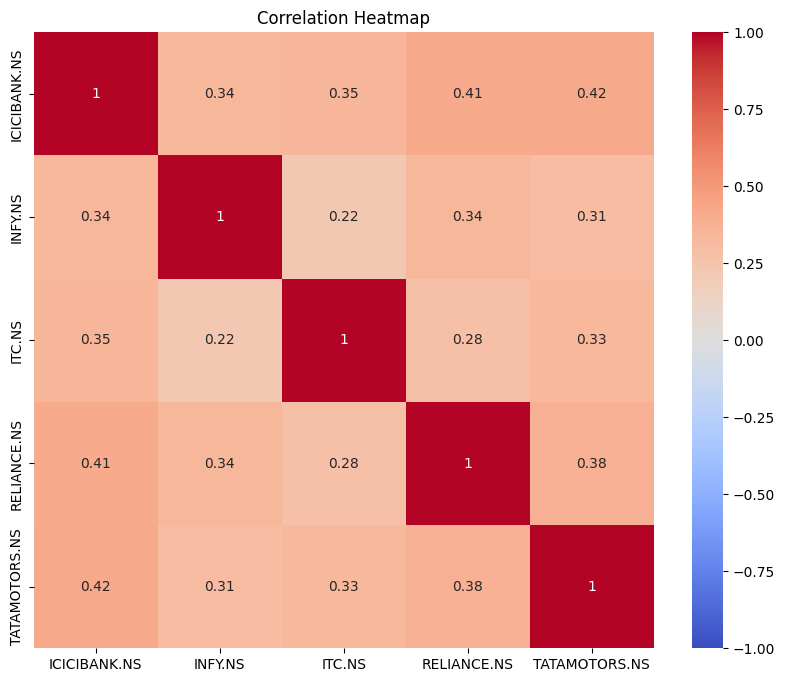

In [18]:
import seaborn as sns

correlation = stock_data.pct_change().corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()


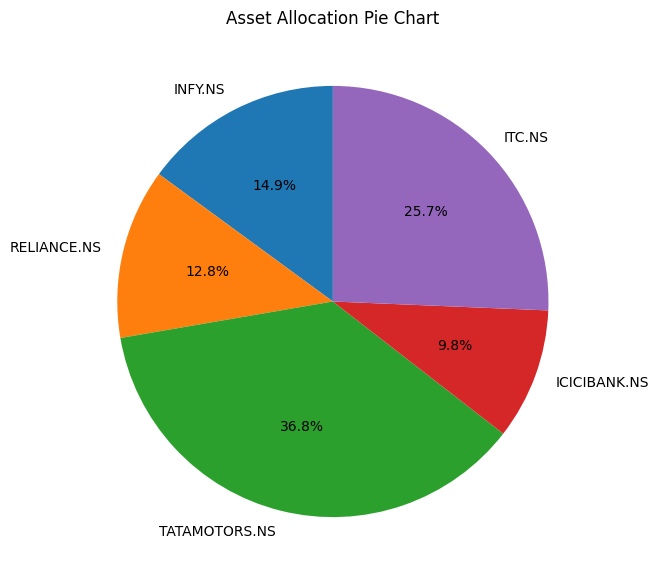

In [19]:
asset_allocation = [allocation[ticker]*latest_prices[ticker] for ticker in tickers]
plt.figure(figsize=(10, 7))
plt.pie(asset_allocation, labels=tickers, autopct='%1.1f%%', startangle=90)
plt.title("Asset Allocation Pie Chart")
plt.show()


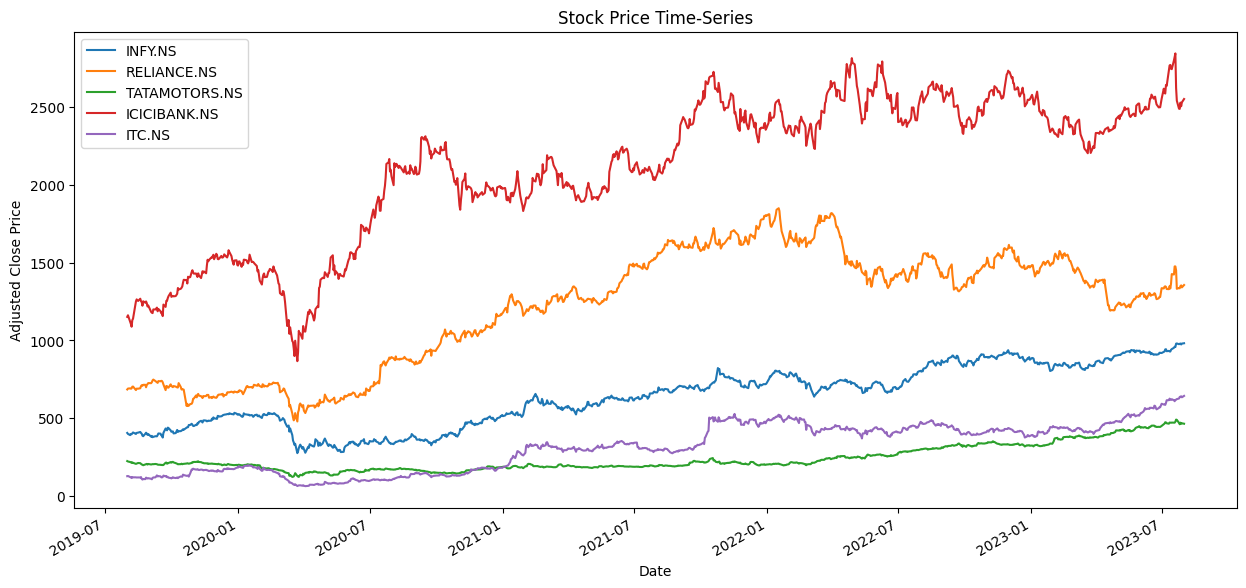

In [20]:
stock_data.plot(figsize=(15, 7))
plt.title('Stock Price Time-Series')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend(tickers)
plt.show()
